### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models

Download plugin model

In [3]:
# pip install ewatercycle-HBV==1.0.0

#### set up paths

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [5]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [6]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

In [7]:
from ewatercycle_HBV.forcing import HBVForcing

In [8]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          forcing_file = "test_forcing.txt",
                          )

In [9]:
ds = test_forcing.to_xarray()

# run containerised model

In [10]:
from ewatercycle_HBV.model import HBV

In [19]:
from ewatercycle.container import ContainerImage
model = HBV(forcing=test_forcing)

In [105]:
config_file, _ = model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [106]:
model.initialize(config_file)

In [107]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q_m"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [23]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

In [24]:
Q_m_in_ref = np.loadtxt("Q_m_out_ref.txt")

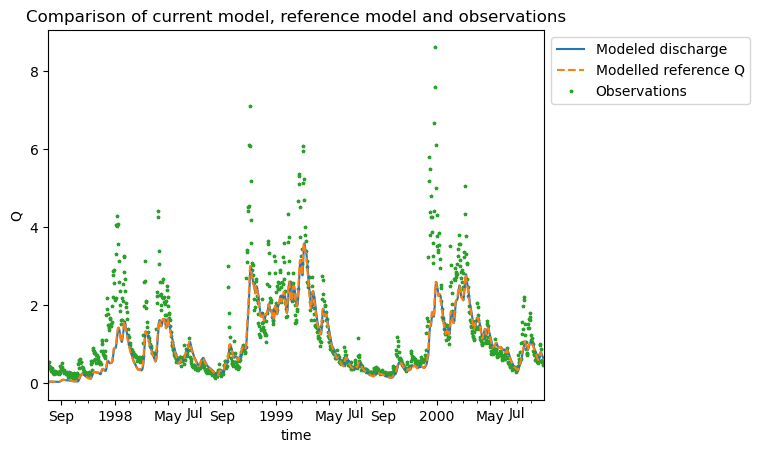

In [27]:
fig, ax = plt.subplots(1,1)
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.plot(df.index, Q_m_in_ref[1:],ls="--",label="Modelled reference Q");
ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=-1,label="Observations")
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Comparison of current model, reference model and observations");

In [28]:
n_particles = 10

In [29]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [35]:
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV(forcing=test_forcing))

In [38]:
for index, ensembleMember in enumerate(ensemble):
    config_file, _ = ensembleMember.setup(
                                          parameters=','.join([str(p) for p in p_intial[index]]), 
                                          initial_storage=','.join([str(s) for s in s_0])
                                         )
    ensembleMember.initialize(config_file)

In [39]:
## TODO: fix file system makeing 100000 models? 

In [60]:
dir(ref_model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_pydantic_core_schema__',
 '__get_pydantic_json_schema__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pretty__',
 '__private_attributes__',
 '__pydantic_complete__',
 '__pydantic_core_schema__',
 '__pydantic_custom_init__',
 '__pydantic_decorators__',
 '__pydantic_extra__',
 '__pydantic_fields_set__',
 '__pydantic_generic_metadata__',
 '__pydantic_init_subclass__',
 '__pydantic_parent_namespace__',
 '__pydantic_post_init__',
 '__pydantic_private__',
 '__pydantic_root_model__',
 '__pydantic_serializer__',
 '__pydantic_validator__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__'

In [61]:
ref_model.time_units

'seconds since 1970-01-01 00:00:00.0 +0000'

In [72]:
# TODO: fix timestep in 1.1

In [76]:
ref_model.time_step # should be 86400 = 24 * 3600 = 1 d

86400000000000.0

In [86]:
ref_model = ensemble[0]
n_timesteps = int((ref_model.end_time - ref_model.start_time) / 86400) # ref_model.timestep 

In [82]:
n_storage_terms = len(s_0)

In [85]:
Q_m_arr = np.zeros((n_particles,n_timesteps))
storage_terms_arr = np.zeros((n_particles, n_timesteps, n_storage_terms))

In [96]:
time = []
t_index = 0 
while model.time < model.end_time:
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        Q_m_arr[index, t_index] = ensembleMember.get_value("Q_m")
        storage_terms = np.array([ensembleMember.get_value("Si"),ensembleMember.get_value("Su"),ensembleMember.get_value("Sf"),ensembleMember.get_value("Ss")]).flatten()
        storage_terms_arr[index, t_index] = storage_terms
    t_index+=1 

In [114]:
df_ensemble = pd.DataFrame(data=Q_m_arr.T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

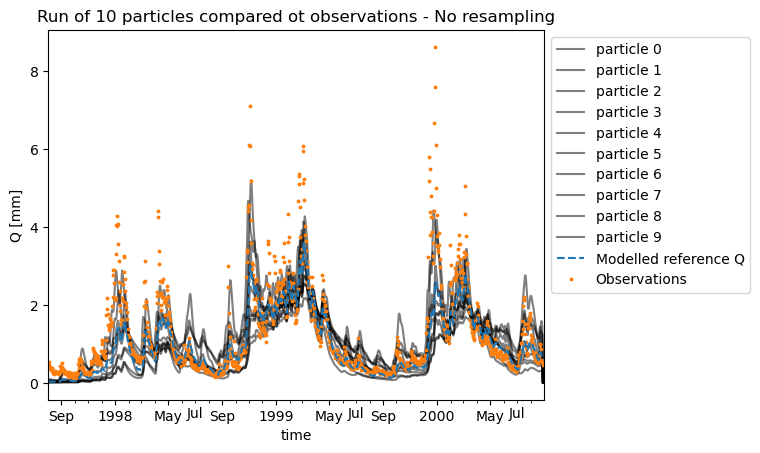

In [119]:
fig, ax = plt.subplots(1,1)
df_ensemble.plot(ax=ax,color="k",alpha=0.5,zorder=-1)
ax.plot(df.index, Q_m_in_ref[1:],ls="--",label="Modelled reference Q");
ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=-1,label="Observations")
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run of {n_particles} particles compared ot observations - No resampling");